In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install scikit-learn --upgrade  
# Upgrade scikit-learn to the latest version

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   --------------- ------------------------ 4.2/11.0 MB 22.9 MB/s eta 0:00:01
   ------------------------------ --------- 8.4/11.0 MB 21.7 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.1
    Uninstalling scikit-learn-1.5.1:
      Successfully uninstalled scikit-learn-1.5.1


  You can safely remove it manually.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Loading the data
df=pd.read_csv('parkingLot (1).csv')

In [4]:
df

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
1,MHYN4677,2024-09-12 05:00:00,1
2,MHEL6595,2024-09-12 05:00:00,1
3,MHNQ2590,2024-09-12 05:00:00,1
4,MHHA0518,2024-09-12 05:00:00,1
...,...,...,...
106689,MHCN7114,2024-11-14 00:00:00,2
106690,MHVY8418,2024-11-14 00:00:00,2
106691,MHSR8102,2024-11-14 00:00:00,2
106692,MHQG5264,2024-11-14 00:00:00,2


In [5]:
df_first=df['vehicle_no']
df_first.sort_values()

12473    0HFB7657
67395    0HLW6417
94687    0HNH1376
7039     1HHN8789
62732    1HSF6006
           ...   
98473         NaN
98474         NaN
98475         NaN
98476         NaN
98477         NaN
Name: vehicle_no, Length: 106694, dtype: object

In [7]:
frequency_df = df.groupby(['timestamp', 'camera_id']).size().reset_index(name='frequency')
df1=frequency_df[frequency_df['camera_id']==1]
df2=frequency_df[frequency_df['camera_id']==2]

# Q1

## Analysis

### Data preprocessing

Lets check for presence of null values in the data.

In [8]:
# printing rows with null values
df.isnull().sum()

vehicle_no    441
timestamp       0
camera_id       0
dtype: int64

Since for the puropse of this questions (finding total number of vehicles per day), the Null values in the data does not matter, as only the vehicle id is null. So it has been considered as an entry and not dropped.

Lets see how the number of vehicles entrying per 20 minutes varies.

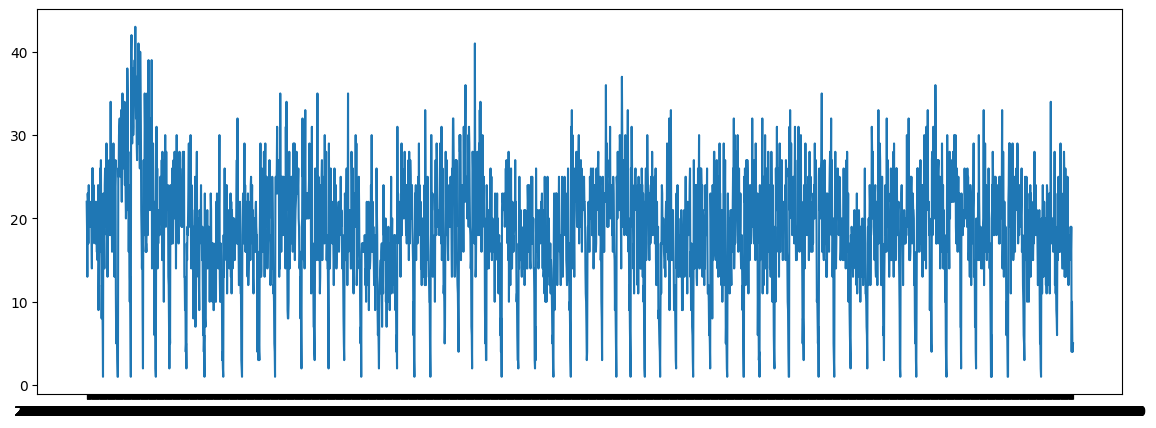

In [9]:
df1
plt.figure(figsize=(14, 5))
plt.plot(df1['timestamp'], df1['frequency'])
plt.show()

To get the number of vehicles entering per day, we can group the camera id 1 data daywise and sum the total number of vehicles recorded by the camera 1 each day.

In [10]:
# using the timestamp of df1, group the data by each day...basically sum the frequency of each day
df1['timestamp'] = pd.to_datetime(df1['timestamp'])
#Only sum the 'frequency' column, excluding the 'timestamp' column
df1_daywise=df1.groupby(df1['timestamp'].dt.date)['frequency'].sum().reset_index()
df1_daywise


C:\Users\Maadurga computer\AppData\Local\Temp\ipykernel_22468\3105945794.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['timestamp'] = pd.to_datetime(df1['timestamp'])


,timestamp,frequency
0,2024-09-12,886
1,2024-09-13,809
2,2024-09-14,925
3,2024-09-15,1073
4,2024-09-16,843
...,...,...
58,2024-11-09,906
59,2024-11-10,944
60,2024-11-11,828
61,2024-11-12,806


### Parameter selection for the model

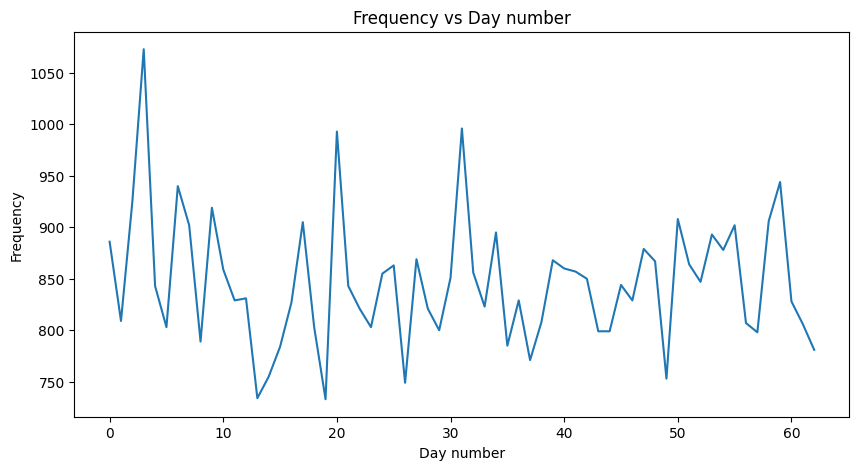

In [11]:
# Plot frequency against index of df1_daywise
plt.figure(figsize=(10, 5))
plt.plot(df1_daywise.index, df1_daywise['frequency'])
plt.xlabel('Day number')
plt.ylabel('Frequency')
plt.title('Frequency vs Day number')
plt.show()

In [12]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    plt.savefig('tsplot.png')
    plt.show()

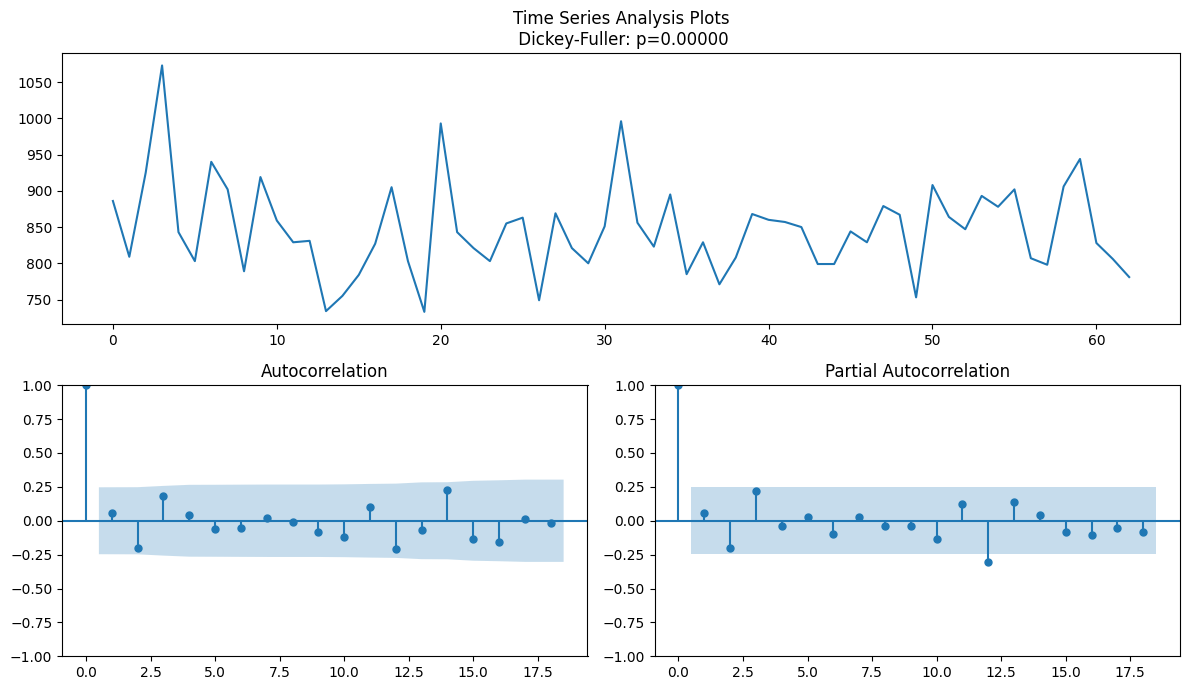

In [13]:
tsplot(df1_daywise['frequency'])

The above plot suggest p=1,d=0,q=1 .

## Model - ARIMA

In [14]:
# Splitting the data into train-test and train daywise prediction model for number of vehicles using arima
from sklearn.model_selection import train_test_split # Changed import to train_test_split
from statsmodels.tsa.arima.model import ARIMA
#Since temporal_train_test_split is not available, use train_test_split with shuffle=False to maintain temporal order.
train, test = train_test_split(df1_daywise, test_size=0.15, shuffle=False)

model = ARIMA(train['frequency'], order=(1,0,1))
print("Started fitting the model")
model_fit = model.fit()

Started fitting the model


c:\Users\Maadurga computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Maadurga computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAPE: 5.447061799093621
MASE: 0.6989149813949505


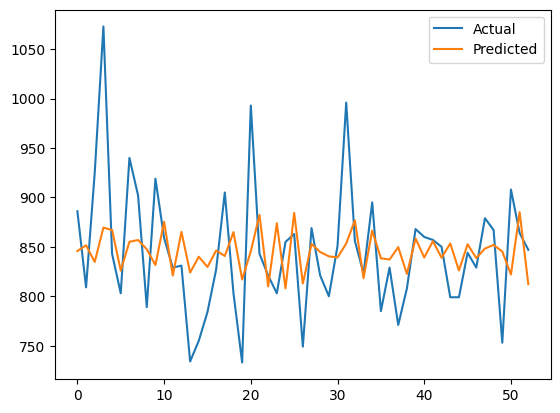

In [15]:
# Predict the previous model on complete train data
predictions_train = model_fit.predict(start=train.index[0], end=train.index[-1])

#Accuracy
mape_train = np.mean(np.abs((train['frequency'].values - predictions_train) / train['frequency'].values)) * 100
print('MAPE:', mape_train)

# MASE
naive_forecast_error = np.abs(np.diff(df1_daywise['frequency'])).mean()
mae_model = np.mean(np.abs(train['frequency'].values - predictions_train))
mase = mae_model / naive_forecast_error
print('MASE:', mase)

#Plot
plt.plot(train['frequency'], label='Actual')
plt.plot(predictions_train, label='Predicted')
plt.legend()
plt.show()


MAPE: 5.505898358701472
MASE: 0.7076115236074316


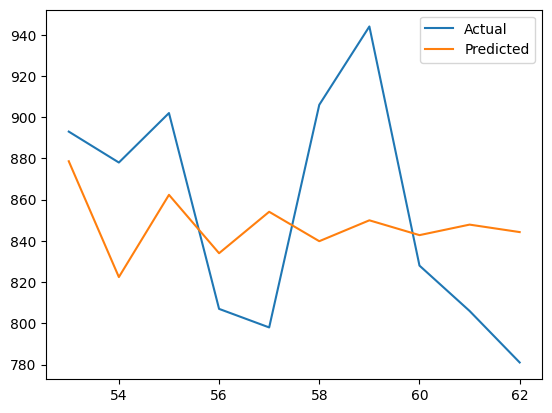

In [16]:
# Test prediction plot
predictions = model_fit.predict(start=test.index[0], end=test.index[-1])

# Find mape on predicited values
mape = np.mean(np.abs((test['frequency'].values - predictions) / test['frequency'].values)) * 100
print('MAPE:', mape)

# Find mean absolute scaled error for seasonal time series data... MASE
naive_forecast_error = np.abs(np.diff(df1_daywise['frequency'])).mean()
mae_model = np.mean(np.abs(test['frequency'].values - predictions))
mase = mae_model / naive_forecast_error
print('MASE:', mase)

# Plot
plt.plot(test['frequency'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


Both Train and Test MAPE is around 5.5% and MASE around 0.7, which is less than 1. Hence the prediction is better than a naive forecast.

## Model - ETS

In [17]:
# make similar model using ets
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model2 = ExponentialSmoothing(train['frequency'], trend=None, seasonal='mul', seasonal_periods=7)
model_fit2 = model2.fit()

MAPE: 5.312407301091139
MASE: 0.6713783690523708


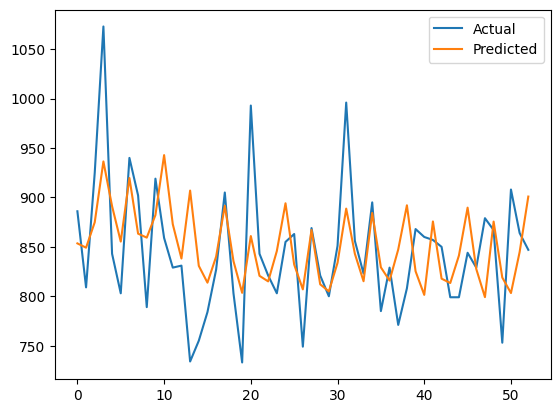

In [18]:
# using ets model, predict, print accuracy and plot on training set
predictions2=model_fit2.predict(start=train.index[0], end=train.index[-1])
# print(model_fit2.summary())

#print accuracy
mape2 = np.mean(np.abs((train['frequency'].values - predictions2) / train['frequency'].values)) * 100
print('MAPE:', mape2)

# MASE
naive_forecast_error = np.abs(np.diff(df1_daywise['frequency'])).mean()
mae_model = np.mean(np.abs(train['frequency'].values - predictions2))
mase = mae_model / naive_forecast_error
print('MASE:', mase)
#plot
plt.plot(train['frequency'], label='Actual')
plt.plot(predictions2, label='Predicted')
plt.legend()
plt.show()

MAPE: 4.635595559616752
MASE: 0.597074368858072


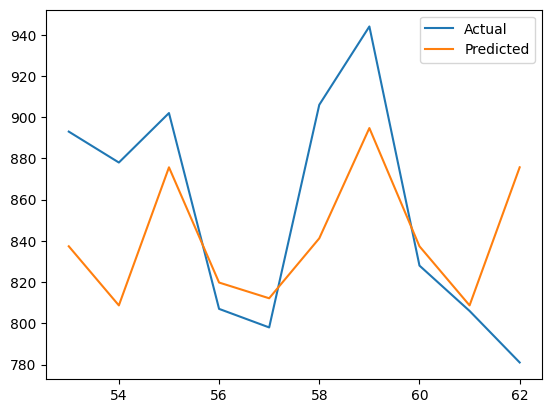

In [19]:
# predict and plot
predictions = model_fit2.predict(start=test.index[0], end=test.index[-1])

#print mape
mape = np.mean(np.abs((test['frequency'].values - predictions) / test['frequency'].values)) * 100
print('MAPE:', mape)
# MASE
naive_forecast_error = np.abs(np.diff(df1_daywise['frequency'])).mean()
mae_model = np.mean(np.abs(test['frequency'].values - predictions))
mase = mae_model / naive_forecast_error
print('MASE:', mase)
#plot
plt.plot(test['frequency'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


Looking at the MAPE and MASE, this model performs slightly better than the ARIMA model. This is our final model used for forecasting the next 7 days after the given data

## Final Model

From the results of previous two models, we are using ETS as our final model to forecast for next seven days.

In [20]:
### same model as before, fitted on complete data
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model3 = ExponentialSmoothing(df1_daywise['frequency'], trend=None, seasonal='mul', seasonal_periods=7)
model_fit3 = model3.fit()

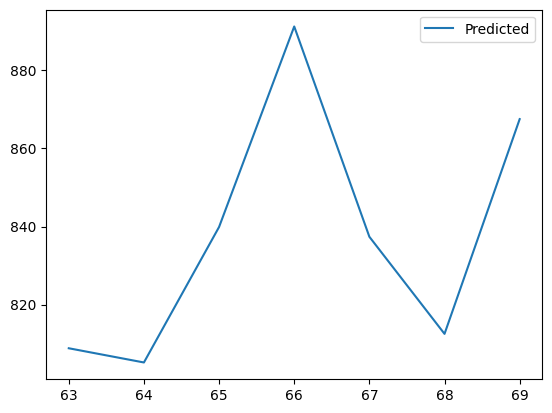

63    808.796965
64    805.152765
65    839.882857
66    891.276195
67    837.373406
68    812.485313
69    867.534453
dtype: float64

In [21]:
### Final forecast for the next 7 days
final_predictions = model_fit3.predict(start=df1_daywise.index[-1] + 1, end=df1_daywise.index[-1] + 7)
plt.plot(final_predictions, label='Predicted')
plt.legend()
plt.show()
final_predictions

The above values have been provided in the report.